In [10]:
# Cell 1: Setup and Unzip
import zipfile
import os

# 1. Unzip the dataset (Assuming you uploaded 'archive.zip' to Colab)
# If your file is named differently, change 'archive.zip' below.
if os.path.exists('archive.zip'):
    with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
        zip_ref.extractall()
    print("✅ Files Unzipped Successfully!")
else:
    print("⚠️ archive.zip not found. Please upload it to the Files tab on the left.")

# 2. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Styling for professional plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
print("📚 Libraries Loaded.")

✅ Files Unzipped Successfully!
📚 Libraries Loaded.


In [11]:
# Cell 2: Load and Combine Data
# Load the CSVs extracted from the zip
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

# Mark them so we can separate them later
train['source'] = 'train'
test['source'] = 'test'

# Concatenate (Stack them on top of each other)
df = pd.concat([train, test], ignore_index=True)

print(f"✅ Data Loaded. Total Rows: {df.shape[0]}")
print("First 5 rows:")
display(df.head())

✅ Data Loaded. Total Rows: 10695
First 5 rows:


,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation,source
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D,train
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A,train
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B,train
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B,train
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A,train


In [12]:
# Cell 3: Data Cleaning
print("Missing values before cleaning:\n", df.isnull().sum())

# 1. Categorical Columns: Fill with Mode
cat_cols = ['Ever_Married', 'Graduated', 'Profession', 'Var_1']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# 2. Numerical Columns: Fill with Median
num_cols = ['Work_Experience', 'Family_Size']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

print("\n✅ Missing values handled.")

Missing values before cleaning:
 ID                    0
Gender                0
Ever_Married        190
Age                   0
Graduated           102
Profession          162
Work_Experience    1098
Spending_Score        0
Family_Size         448
Var_1               108
Segmentation       2627
source                0
dtype: int64

✅ Missing values handled.


In [13]:
# Cell 4: Encoding and Scaling

# 1. Ordinal Encoding (Order matters: Low < Average < High)
spending_map = {'Low': 0, 'Average': 1, 'High': 2}
df['Spending_Score'] = df['Spending_Score'].map(spending_map)

# 2. Label Encoding (No order: Male/Female, Artist/Doctor)
le = LabelEncoder()
encode_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Var_1']
for col in encode_cols:
    df[col] = le.fit_transform(df[col])

# 3. Feature Selection & Scaling
# We drop 'ID' (useless) and 'Segmentation' (the answer key)
features = ['Gender', 'Ever_Married', 'Age', 'Graduated', 'Profession',
            'Work_Experience', 'Spending_Score', 'Family_Size', 'Var_1']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

print("✅ Data Encoded and Scaled. Ready for Clustering.")

✅ Data Encoded and Scaled. Ready for Clustering.


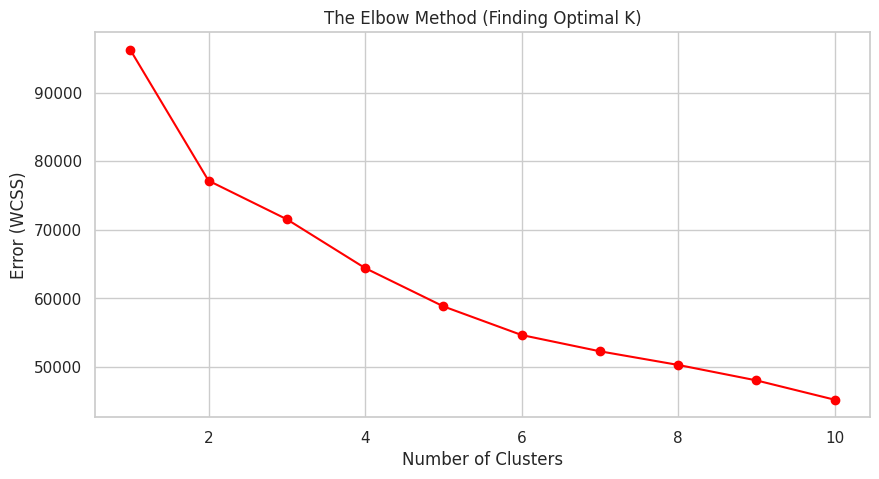

💡 Look for the 'Elbow' bend. It should be around K=4.


In [14]:
# Cell 5: The Elbow Method
wcss = [] # Within-Cluster Sum of Squares (Error)

# Try K from 1 to 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot
plt.figure(figsize=(10,5))
plt.plot(range(1, 11), wcss, marker='o', color='red')
plt.title('The Elbow Method (Finding Optimal K)')
plt.xlabel('Number of Clusters')
plt.ylabel('Error (WCSS)')
plt.show()
print("💡 Look for the 'Elbow' bend. It should be around K=4.")

In [15]:
# Cell 6: Training the Model
# We chose K=4 based on the Elbow plot (and the dataset knowledge)
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)

# Predict clusters for all data
clusters = kmeans.fit_predict(X_scaled)

# Add the prediction back to our original DataFrame
df['Predicted_Cluster'] = clusters

print("✅ Clustering Complete. Every customer is now assigned to Group 0, 1, 2, or 3.")

✅ Clustering Complete. Every customer is now assigned to Group 0, 1, 2, or 3.


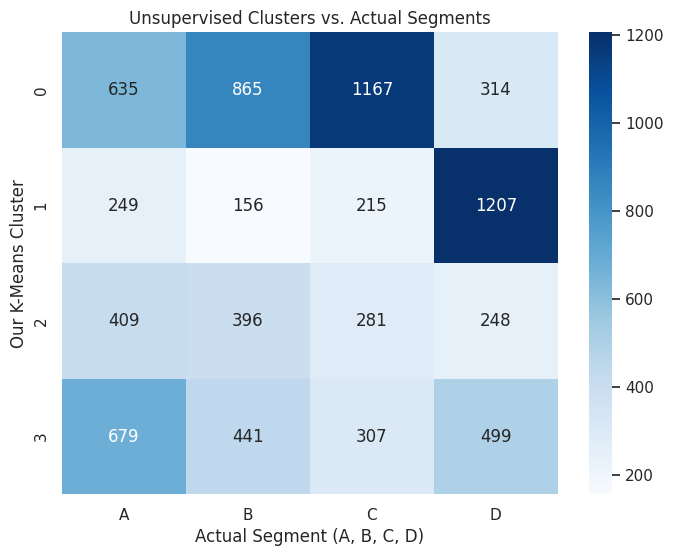

🔍 Analysis:
Look for dark blue squares. Example: Does Cluster 2 overlap heavily with Segment D?


In [16]:
# Cell 7: Evaluation (Cluster vs Actual)
# Filter only the Training data (because Test data doesn't have answers)
train_results = df[df['source'] == 'train']

# Create a Confusion Matrix (Cross-Tabulation)
cm = pd.crosstab(train_results['Predicted_Cluster'], train['Segmentation'])

# Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Unsupervised Clusters vs. Actual Segments')
plt.ylabel('Our K-Means Cluster')
plt.xlabel('Actual Segment (A, B, C, D)')
plt.show()

print("🔍 Analysis:")
print("Look for dark blue squares. Example: Does Cluster 2 overlap heavily with Segment D?")